In [1]:
import torch
import os
import numpy as np
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F
from PIL import Image
import cv2
from tqdm import tqdm, trange
from numba import njit
import fastremap
from scipy.ndimage import maximum_filter1d, find_objects

/home/fantashi099/miniconda3/envs/cellpose/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3) -> None:
        super(ConvBlock, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)
    

class SkipConv(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(SkipConv, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.net(x)


class ResDown(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3) -> None:
        super(ResDown, self).__init__()

        self.skip_conv = SkipConv(in_channels, out_channels)
        self.net = nn.Sequential(OrderedDict([
            ("conv_0", ConvBlock(in_channels, out_channels, kernel_size)),
            ("conv_1", ConvBlock(out_channels, out_channels, kernel_size)),
            ("conv_2", ConvBlock(out_channels, out_channels, kernel_size)),
            ("conv_3", ConvBlock(out_channels, out_channels, kernel_size)),
        ]))

    def forward(self, x):
        skip_connect = self.skip_conv(x)
        first_block = self.net[1](self.net[0](x)) + skip_connect
        second_block = first_block + self.net[3](self.net[2](first_block))
        return second_block
    

class DownSample(nn.Module):
    def __init__(self, c_hiddens=[2,32,64,128,256], kernel_size=3) -> None:
        super(DownSample, self).__init__()

        self.maxpool = nn.MaxPool2d(2,2)
        self.net = nn.Sequential()

        for idx in range(len(c_hiddens[:-1])):
            self.net.add_module("Resdown_%d" %idx, ResDown(c_hiddens[idx], c_hiddens[idx+1], kernel_size))

    def forward(self, x):
        down_res = []
        for idx in range(len(self.net)):
            x = self.net[idx](x)
            if idx > 0:
                x = self.maxpool(x)
            down_res.append(x)
        return down_res


class MakeStyle(nn.Module):
    def __init__(self,) -> None:
        super(MakeStyle, self).__init__()

        self.flatten = nn.Flatten()
    
    def forward(self, x):
        style = F.avg_pool2d(x, kernel_size=(x.shape[-2:]))
        style = self.flatten(style)
        style = style / torch.sum(style**2, axis=1, keepdim=True)**.5

        return style


class ResUp(nn.Module):
    def __init__(self, in_channels, out_channels, style_channels=256, kernel_size=3) -> None:
        super(ResUp, self).__init__()

        self.skip_conv = SkipConv(in_channels, out_channels)
        self.net = nn.Sequential(OrderedDict([
            ("conv_0", ConvBlock(in_channels, out_channels, kernel_size)),
            ("conv_1", ConvBlock(out_channels*2, out_channels, kernel_size)),
            ("conv_2", ConvBlock(out_channels, out_channels, kernel_size)),
            ("conv_3", ConvBlock(out_channels, out_channels, kernel_size)),
        ]))
        self.fc = nn.Sequential(OrderedDict([
            ("fc_0", nn.Linear(style_channels, out_channels*2)),
            ("fc_1", nn.Linear(style_channels, out_channels)),
            ("fc_2", nn.Linear(style_channels, out_channels)),
        ]))

    def forward(self, x, y_resdown, style):
        skip_connect = self.skip_conv(x)
        x = torch.cat((self.net[0](x), y_resdown), dim=1) + self.fc[0](style).unsqueeze(-1).unsqueeze(-1)
        x = self.net[1](x) + skip_connect

        second_block = x
        x = x + self.fc[1](style).unsqueeze(-1).unsqueeze(-1)
        x = self.net[2](x) + self.fc[2](style).unsqueeze(-1).unsqueeze(-1)
        x = self.net[3](x) + second_block
        return x


class UpSample(nn.Module):
    def __init__(self, c_hiddens=[256,256,128,64,32]) -> None:
        super(UpSample, self).__init__()

        self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
        self.net = nn.Sequential()

        for idx in range(len(c_hiddens[:-1])):
            self.net.add_module("ResUp_%d" %idx, ResUp(c_hiddens[idx], c_hiddens[idx+1]))
    
    def forward(self, x, style, out_resdown):
        for idx in range(len(self.net)):
            x = self.net[idx](x, out_resdown[idx], style)
            if idx < len(self.net) - 1:
                x = self.upsampling(x)
        return x

class CellPose(nn.Module):
    def __init__(self, c_hiddens:list=[2,32,64,128,256], diam_mean:float=30.0) -> None:
        super(CellPose, self).__init__()

        nclasses = 3
        c_down = c_hiddens
        c_up = [c_hiddens[-1]] + c_hiddens[::-1][:-1]
        self.c_down = c_down
        self.c_up = c_up
        self.down_model = DownSample(c_hiddens=c_down)
        self.up_model = UpSample(c_hiddens=c_up)
        self.style = MakeStyle()
        self.head = ConvBlock(c_up[-1], nclasses, 1)
        self.diam_mean = nn.Parameter(data=torch.ones(1) * diam_mean, requires_grad=False)
        self.diam_labels = nn.Parameter(data=torch.ones(1) * diam_mean, requires_grad=False)

    def forward(self, x):
        out_resdown = self.down_model(x)
        vector_style = self.style(out_resdown[-1])
        out_resup = self.up_model(out_resdown[-1], vector_style, out_resdown[::-1])

        final_result = self.head(out_resup)
        return final_result, vector_style

    def save_model(self, filename):
        torch.save(self.state_dict(), filename)
    
    def load_model(self, filename, device=None):
        state_dict = torch.load(filename, map_location=torch.device(device))
        self.load_state_dict(dict([(name, param) for name, param in state_dict.items()]), strict=False)


In [18]:
from torch.optim import Adam

def random_rotate_and_resize(X, Y=None, scale_range=1., xy = (224,224), 
                             do_flip=True, rescale=None, random_per_image=True):
    """ augmentation by random rotation and resizing
        X and Y are lists or arrays of length nimg, with dims channels x Ly x Lx (channels optional)
        Parameters
        ----------
        X: LIST of ND-arrays, float
            list of image arrays of size [nchan x Ly x Lx] or [Ly x Lx]
        Y: LIST of ND-arrays, float (optional, default None)
            list of image labels of size [nlabels x Ly x Lx] or [Ly x Lx]. The 1st channel
            of Y is always nearest-neighbor interpolated (assumed to be masks or 0-1 representation).
            If Y.shape[0]==3, then the labels are assumed to be [cell probability, Y flow, X flow]. 
        scale_range: float (optional, default 1.0)
            Range of resizing of images for augmentation. Images are resized by
            (1-scale_range/2) + scale_range * np.random.rand()
        xy: tuple, int (optional, default (224,224))
            size of transformed images to return
        do_flip: bool (optional, default True)
            whether or not to flip images horizontally
        rescale: array, float (optional, default None)
            how much to resize images by before performing augmentations
        random_per_image: bool (optional, default True)
            different random rotate and resize per image
        Returns
        -------
        imgi: ND-array, float
            transformed images in array [nimg x nchan x xy[0] x xy[1]]
        lbl: ND-array, float
            transformed labels in array [nimg x nchan x xy[0] x xy[1]]
        scale: array, float
            amount each image was resized by
    """
    scale_range = max(0, min(2, float(scale_range)))
    nimg = len(X)
    if X[0].ndim>2:
        nchan = X[0].shape[0]
    else:
        nchan = 1
    imgi  = np.zeros((nimg, nchan, xy[0], xy[1]), np.float32)

    lbl = []
    if Y is not None:
        if Y[0].ndim>2:
            nt = Y[0].shape[0]
        else:
            nt = 1
        lbl = np.zeros((nimg, nt, xy[0], xy[1]), np.float32)

    scale = np.ones(nimg, np.float32)
    
    for n in range(nimg):
        Ly, Lx = X[n].shape[-2:]

        if random_per_image or n==0:
            # generate random augmentation parameters
            flip = np.random.rand()>.5
            theta = np.random.rand() * np.pi * 2
            scale[n] = (1-scale_range/2) + scale_range * np.random.rand()
            if rescale is not None:
                scale[n] *= 1. / rescale[n]
            dxy = np.maximum(0, np.array([Lx*scale[n]-xy[1],Ly*scale[n]-xy[0]]))
            dxy = (np.random.rand(2,) - .5) * dxy

            # create affine transform
            cc = np.array([Lx/2, Ly/2])
            cc1 = cc - np.array([Lx-xy[1], Ly-xy[0]])/2 + dxy
            pts1 = np.float32([cc,cc + np.array([1,0]), cc + np.array([0,1])])
            pts2 = np.float32([cc1,
                    cc1 + scale[n]*np.array([np.cos(theta), np.sin(theta)]),
                    cc1 + scale[n]*np.array([np.cos(np.pi/2+theta), np.sin(np.pi/2+theta)])])
            M = cv2.getAffineTransform(pts1,pts2)

        img = X[n].copy()
        if Y is not None:
            labels = Y[n].copy()
            if labels.ndim<3:
                labels = labels[np.newaxis,:,:]

        if flip and do_flip:
            img = img[..., ::-1]
            if Y is not None:
                labels = labels[..., ::-1]
                if nt > 1:
                    labels[2] = -labels[2]

        for k in range(nchan):
            I = cv2.warpAffine(img[k], M, (xy[1],xy[0]), flags=cv2.INTER_LINEAR)
            imgi[n,k] = I

        if Y is not None:
            for k in range(nt):
                if k==0:
                    lbl[n,k] = cv2.warpAffine(labels[k], M, (xy[1],xy[0]), flags=cv2.INTER_NEAREST)
                else:
                    lbl[n,k] = cv2.warpAffine(labels[k], M, (xy[1],xy[0]), flags=cv2.INTER_LINEAR)

            if nt > 1:
                v1 = lbl[n,2].copy()
                v2 = lbl[n,1].copy()
                lbl[n,1] = (-v1 * np.sin(-theta) + v2*np.cos(-theta))
                lbl[n,2] = (v1 * np.cos(-theta) + v2*np.sin(-theta))

    return imgi, lbl, scale

def diameters(masks):
    median = []
    for idx in range(masks.shape[0]):
        _, counts = np.unique(np.int32(masks[idx]), return_counts=True)
        counts = counts[1:] # remove background - 0
        if len(counts) > 0:
            md = np.median(counts)
        else:
            md = 0
        md /= (np.pi**0.5)/2
        median.append(md)
    return np.median(median)


def loss_fn(lbl, y, criterion, criterion2):
    """ loss function between true labels lbl and prediction y """
    veci = 5. * torch.from_numpy(lbl[:,1:]).to("cpu").float()
    lbl  = torch.from_numpy(lbl[:,0]>.5).to("cpu").float()
    loss = criterion(y[:,:2] , veci) 
    loss /= 2.
    loss2 = criterion2(y[:,2] , lbl)
    loss = loss + loss2
    return loss

def _train_net(X_train, y_train, X_test, y_test, model, save_path=None, diam_mean=30, save_every=100, learning_rate=3e-10, n_epochs=200, momentum=0.9, weight_decay=1e-6, batch_size=2, rescale=True, model_name=None, device="cuda"):
    optimizer = Adam(model.parameters(), lr=learning_rate, betas=(0.95,0.999),weight_decay=weight_decay)
    
    criterion  = nn.MSELoss(reduction='mean')
    criterion2 = nn.BCEWithLogitsLoss(reduction='mean')

    # compute average cell diameter
    diam_train = np.array([diameters(y_train[idx]) for idx in range(len(y_train))])
    diam_train_mean = diam_train[diam_train > 0].mean()

    if rescale:
        diam_train[diam_train<5] = 5.0
        if X_test is not None:
            diam_test = np.array([(y_test[idx]) for idx in range(len(y_test))])
            diam_test[diam_test<5] = 5.0
        scale_range = 0.5
    else:
        scale_range = 1.0

    model.diam_labels.data = torch.ones(1, device=device) * diam_train_mean
    
    n_channels = X_train[0].shape[0]
    n_imgs = len(X_train)
    loss_avg, nsum = 0, 0

    if save_path is not None:
        fdir = os.path.join(save_path, "models/")

        if not os.path.exists(fdir):
            os.makedirs(fdir)
    
    model.train()
    for epoch in range(n_epochs):
        indices = np.random.permutation(n_imgs)
        for batch in tqdm(range(0, n_imgs, batch_size)):
            inds = indices[batch:batch+batch_size]
            rsc = diam_train[inds] / diam_mean if rescale else np.ones(len(inds), np.float32)

            img, label, scale = random_rotate_and_resize(
                [X_train[idx] for idx in inds], Y=[y_train[idx][1:] for idx in inds],
                rescale=rsc, scale_range=scale_range
            )
            img = torch.from_numpy(img).float().to(device)
            optimizer.zero_grad()
            out = model(img)[0]

            loss = loss_fn(label, out, criterion, criterion2)
            loss.backward()

            train_loss = loss.item()
            optimizer.step()
            train_loss *= len(img)

            loss_avg += train_loss
            nsum += len(img)
        
        loss_avg /= nsum
        print("Epoch %d, Loss %2.4f, LR %2.4f" % (epoch, loss_avg, learning_rate))
            

In [5]:
def reshape(data, channels=[0,0], chan_first=False):
    """ reshape data using channels

    Parameters
    ----------

    data : numpy array that's (Z x ) Ly x Lx x nchan
        if data.ndim==8 and data.shape[0]<8, assumed to be nchan x Ly x Lx

    channels : list of int of length 2 (optional, default [0,0])
        First element of list is the channel to segment (0=grayscale, 1=red, 2=green, 3=blue).
        Second element of list is the optional nuclear channel (0=none, 1=red, 2=green, 3=blue).
        For instance, to train on grayscale images, input [0,0]. To train on images with cells
        in green and nuclei in blue, input [2,3].

    Returns
    -------
    data : numpy array that's (Z x ) Ly x Lx x nchan (if chan_first==False)

    """
    data = data.astype(np.float32)
    if data.ndim < 3:
        data = data[:,:,np.newaxis]
    elif data.shape[0]<8 and data.ndim==3:
        data = np.transpose(data, (1,2,0))

    # use grayscale image
    if data.shape[-1]==1:
        data = np.concatenate((data, np.zeros_like(data)), axis=-1)
    else:
        if channels[0]==0:
            data = data.mean(axis=-1, keepdims=True)
            data = np.concatenate((data, np.zeros_like(data)), axis=-1)
        else:
            chanid = [channels[0]-1]
            if channels[1] > 0:
                chanid.append(channels[1]-1)
            data = data[...,chanid]
            for i in range(data.shape[-1]):
                if np.ptp(data[...,i]) == 0.0:
                    if i==0:
                        warnings.warn("chan to seg' has value range of ZERO")
                    else:
                        warnings.warn("'chan2 (opt)' has value range of ZERO, can instead set chan2 to 0")
            if data.shape[-1]==1:
                data = np.concatenate((data, np.zeros_like(data)), axis=-1)
    if chan_first:
        if data.ndim==4:
            data = np.transpose(data, (3,0,1,2))
        else:
            data = np.transpose(data, (2,0,1))
    return data


def normalize99(Y, lower=1,upper=99):
    """ normalize image so 0.0 is 1st percentile and 1.0 is 99th percentile """
    X = Y.copy()
    x01 = np.percentile(X, lower)
    x99 = np.percentile(X, upper)
    X = (X - x01) / (x99 - x01)
    return X

def normalize_img(img, axis=-1, invert=False):
    """ normalize each channel of the image so that so that 0.0=1st percentile
    and 1.0=99th percentile of image intensities

    optional inversion

    Parameters
    ------------

    img: ND-array (at least 3 dimensions)

    axis: channel axis to loop over for normalization

    invert: invert image (useful if cells are dark instead of bright)

    Returns
    ---------------

    img: ND-array, float32
        normalized image of same size

    """
    img = img.astype(np.float32)
    img = np.moveaxis(img, axis, 0)
    for k in range(img.shape[0]):
        # ptp can still give nan's with weird images
        i99 = np.percentile(img[k],99)
        i1 = np.percentile(img[k],1)
        if i99 - i1 > +1e-3: #np.ptp(img[k]) > 1e-3:
            img[k] = normalize99(img[k])
            if invert:
                img[k] = -1*img[k] + 1   
        else:
            img[k] = 0
    img = np.moveaxis(img, 0, axis)
    return img

def reshape_and_normalize_data(train_data, test_data=None, channels=None, normalize=True):
    """ inputs converted to correct shapes for *training* and rescaled so that 0.0=1st percentile
    and 1.0=99th percentile of image intensities in each channel

    Parameters
    --------------

    train_data: list of ND-arrays, float
        list of training images of size [Ly x Lx], [nchan x Ly x Lx], or [Ly x Lx x nchan]

    test_data: list of ND-arrays, float (optional, default None)
        list of testing images of size [Ly x Lx], [nchan x Ly x Lx], or [Ly x Lx x nchan]

    channels: list of int of length 2 (optional, default None)
        First element of list is the channel to segment (0=grayscale, 1=red, 2=green, 3=blue).
        Second element of list is the optional nuclear channel (0=none, 1=red, 2=green, 3=blue).
        For instance, to train on grayscale images, input [0,0]. To train on images with cells
        in green and nuclei in blue, input [2,3].

    normalize: bool (optional, True)
        normalize data so 0.0=1st percentile and 1.0=99th percentile of image intensities in each channel

    Returns
    -------------

    train_data: list of ND-arrays, float
        list of training images of size [2 x Ly x Lx]

    test_data: list of ND-arrays, float (optional, default None)
        list of testing images of size [2 x Ly x Lx]

    run_test: bool
        whether or not test_data was correct size and is useable during training

    """
    # run_test = False
    for test, data in enumerate([train_data, test_data]):
        if data is None:
            return train_data, test_data
        nimg = len(data)
        for i in range(nimg):
            if channels is not None:
                # data[i] = move_min_dim(data[i], force=True)
                data[i] = reshape(data[i], channels=channels, chan_first=True)
            if data[i].ndim < 3:
                data[i] = data[i][np.newaxis,:,:]
            if normalize:
                data[i] = normalize_img(data[i], axis=0)

    # run_test = True
    return train_data, test_data


In [6]:

@njit('(float64[:], int32[:], int32[:], int32, int32, int32, int32)', nogil=True)
def _extend_centers(T,y,x,ymed,xmed,Lx, niter):
    """ run diffusion from center of mask (ymed, xmed) on mask pixels (y, x)
    Parameters
    --------------
    T: float64, array
        _ x Lx array that diffusion is run in
    y: int32, array
        pixels in y inside mask
    x: int32, array
        pixels in x inside mask
    ymed: int32
        center of mask in y
    xmed: int32
        center of mask in x
    Lx: int32
        size of x-dimension of masks
    niter: int32
        number of iterations to run diffusion
    Returns
    ---------------
    T: float64, array
        amount of diffused particles at each pixel
    """

    for t in range(niter):
        T[ymed*Lx + xmed] += 1
        T[y*Lx + x] = 1/9. * (T[y*Lx + x] + T[(y-1)*Lx + x]   + T[(y+1)*Lx + x] +
                                            T[y*Lx + x-1]     + T[y*Lx + x+1] +
                                            T[(y-1)*Lx + x-1] + T[(y-1)*Lx + x+1] +
                                            T[(y+1)*Lx + x-1] + T[(y+1)*Lx + x+1])
    return T



def _extend_centers_gpu(neighbors, centers, isneighbor, Ly, Lx, n_iter=200, device=torch.device('cuda')):
    """ runs diffusion on GPU to generate flows for training images or quality control
    
    neighbors is 9 x pixels in masks, 
    centers are mask centers, 
    isneighbor is valid neighbor boolean 9 x pixels
    
    """
    if device is not None:
        device = device
    nimg = neighbors.shape[0] // 9
    pt = torch.from_numpy(neighbors).to(device)
    
    T = torch.zeros((nimg,Ly,Lx), dtype=torch.double, device=device)
    meds = torch.from_numpy(centers.astype(int)).to(device).long()
    isneigh = torch.from_numpy(isneighbor).to(device)
    for i in range(n_iter):
        T[:, meds[:,0], meds[:,1]] +=1
        Tneigh = T[:, pt[:,:,0], pt[:,:,1]]
        Tneigh *= isneigh
        T[:, pt[0,:,0], pt[0,:,1]] = Tneigh.mean(axis=1)
    del meds, isneigh, Tneigh
    T = torch.log(1.+ T)
    # gradient positions
    grads = T[:, pt[[2,1,4,3],:,0], pt[[2,1,4,3],:,1]]
    del pt
    dy = grads[:,0] - grads[:,1]
    dx = grads[:,2] - grads[:,3]
    del grads
    mu_torch = np.stack((dy.cpu().squeeze(0), dx.cpu().squeeze(0)), axis=-2)
    return mu_torch


def masks_to_flows_gpu(masks, device=None):
    """ convert masks to flows using diffusion from center pixel
    Center of masks where diffusion starts is defined using COM
    Parameters
    -------------
    masks: int, 2D or 3D array
        labelled masks 0=NO masks; 1,2,...=mask labels
    Returns
    -------------
    mu: float, 3D or 4D array 
        flows in Y = mu[-2], flows in X = mu[-1].
        if masks are 3D, flows in Z = mu[0].
    mu_c: float, 2D or 3D array
        for each pixel, the distance to the center of the mask 
        in which it resides 
    """
    if device is None:
        device = torch.device('cuda')

    
    Ly0,Lx0 = masks.shape
    Ly, Lx = Ly0+2, Lx0+2

    masks_padded = np.zeros((Ly, Lx), np.int64)
    masks_padded[1:-1, 1:-1] = masks

    # get mask pixel neighbors
    y, x = np.nonzero(masks_padded)
    neighborsY = np.stack((y, y-1, y+1, 
                           y, y, y-1, 
                           y-1, y+1, y+1), axis=0)
    neighborsX = np.stack((x, x, x, 
                           x-1, x+1, x-1, 
                           x+1, x-1, x+1), axis=0)
    neighbors = np.stack((neighborsY, neighborsX), axis=-1)

    # get mask centers
    slices = find_objects(masks)
    
    centers = np.zeros((masks.max(), 2), 'int')
    for i,si in enumerate(slices):
        if si is not None:
            sr,sc = si
            ly, lx = sr.stop - sr.start + 1, sc.stop - sc.start + 1
            yi,xi = np.nonzero(masks[sr, sc] == (i+1))
            yi = yi.astype(np.int32) + 1 # add padding
            xi = xi.astype(np.int32) + 1 # add padding
            ymed = np.median(yi)
            xmed = np.median(xi)
            imin = np.argmin((xi-xmed)**2 + (yi-ymed)**2)
            xmed = xi[imin]
            ymed = yi[imin]
            centers[i,0] = ymed + sr.start 
            centers[i,1] = xmed + sc.start

    # get neighbor validator (not all neighbors are in same mask)
    neighbor_masks = masks_padded[neighbors[:,:,0], neighbors[:,:,1]]
    isneighbor = neighbor_masks == neighbor_masks[0]
    ext = np.array([[sr.stop - sr.start + 1, sc.stop - sc.start + 1] for sr, sc in slices])
    n_iter = 2 * (ext.sum(axis=1)).max()
    # run diffusion
    mu = _extend_centers_gpu(neighbors, centers, isneighbor, Ly, Lx, 
                             n_iter=n_iter, device=device)

    # normalize
    mu /= (1e-20 + (mu**2).sum(axis=0)**0.5)

    # put into original image
    mu0 = np.zeros((2, Ly0, Lx0))
    mu0[:, y-1, x-1] = mu
    mu_c = np.zeros_like(mu0)
    return mu0, mu_c



def masks_to_flows_cpu(masks, device=None):
    """ convert masks to flows using diffusion from center pixel
    Center of masks where diffusion starts is defined to be the 
    closest pixel to the median of all pixels that is inside the 
    mask. Result of diffusion is converted into flows by computing
    the gradients of the diffusion density map. 
    Parameters
    -------------
    masks: int, 2D array
        labelled masks 0=NO masks; 1,2,...=mask labels
    Returns
    -------------
    mu: float, 3D array 
        flows in Y = mu[-2], flows in X = mu[-1].
        if masks are 3D, flows in Z = mu[0].
    mu_c: float, 2D array
        for each pixel, the distance to the center of the mask 
        in which it resides 
    """
    
    Ly, Lx = masks.shape
    mu = np.zeros((2, Ly, Lx), np.float64)
    mu_c = np.zeros((Ly, Lx), np.float64)
    
    nmask = masks.max()
    slices = find_objects(masks)
    dia = diameters(masks)
    s2 = (.15 * dia)**2
    for i,si in enumerate(slices):
        if si is not None:
            sr,sc = si
            ly, lx = sr.stop - sr.start + 1, sc.stop - sc.start + 1
            y,x = np.nonzero(masks[sr, sc] == (i+1))
            y = y.astype(np.int32) + 1
            x = x.astype(np.int32) + 1
            ymed = np.median(y)
            xmed = np.median(x)
            imin = np.argmin((x-xmed)**2 + (y-ymed)**2)
            xmed = x[imin]
            ymed = y[imin]
            
            d2 = (x-xmed)**2 + (y-ymed)**2
            mu_c[sr.start+y-1, sc.start+x-1] = np.exp(-d2/s2)

            niter = 2*np.int32(np.ptp(x) + np.ptp(y))
            T = np.zeros((ly+2)*(lx+2), np.float64)
            T = _extend_centers(T, y, x, ymed, xmed, np.int32(lx), np.int32(niter))
            T[(y+1)*lx + x+1] = np.log(1.+T[(y+1)*lx + x+1])

            dy = T[(y+1)*lx + x] - T[(y-1)*lx + x]
            dx = T[y*lx + x+1] - T[y*lx + x-1]
            mu[:, sr.start+y-1, sc.start+x-1] = np.stack((dy,dx))

    mu /= (1e-20 + (mu**2).sum(axis=0)**0.5)

    return mu, mu_c

def labels_to_flows(labels, files=None, use_gpu=False, device=None, redo_flows=False):
    """ convert labels (list of masks or flows) to flows for training model 

    if files is not None, flows are saved to files to be reused

    Parameters
    --------------

    labels: list of ND-arrays
        labels[k] can be 2D or 3D, if [3 x Ly x Lx] then it is assumed that flows were precomputed.
        Otherwise labels[k][0] or labels[k] (if 2D) is used to create flows and cell probabilities.

    Returns
    --------------

    flows: list of [4 x Ly x Lx] arrays
        flows[k][0] is labels[k], flows[k][1] is cell distance transform, flows[k][2] is Y flow,
        flows[k][3] is X flow, and flows[k][4] is heat distribution

    """
    nimg = len(labels)
    if labels[0].ndim < 3:
        labels = [labels[n][np.newaxis,:,:] for n in range(nimg)]

    if labels[0].shape[0] == 1 or labels[0].ndim < 3 or redo_flows: # flows need to be recomputed
        
        # compute flows; labels are fixed here to be unique, so they need to be passed back
        # make sure labels are unique!
        labels = [fastremap.renumber(label, in_place=True)[0] for label in labels]
        veci = [masks_to_flows(labels[n][0],use_gpu=use_gpu, device=device) for n in trange(nimg)]
        
        # concatenate labels, distance transform, vector flows, heat (boundary and mask are computed in augmentations)
        flows = [np.concatenate((labels[n], labels[n]>0.5, veci[n]), axis=0).astype(np.float32)
                    for n in range(nimg)]
        if files is not None:
            for flow, file in zip(flows, files):
                file_name = os.path.splitext(file)[0]
                tifffile.imwrite(file_name+'_flows.tif', flow)
    else:
        flows = [labels[n].astype(np.float32) for n in range(nimg)]
    return flows

def masks_to_flows(masks, use_gpu=False, device=None):
    """ convert masks to flows using diffusion from center pixel

    Center of masks where diffusion starts is defined to be the 
    closest pixel to the median of all pixels that is inside the 
    mask. Result of diffusion is converted into flows by computing
    the gradients of the diffusion density map. 

    Parameters
    -------------

    masks: int, 2D or 3D array
        labelled masks 0=NO masks; 1,2,...=mask labels

    Returns
    -------------

    mu: float, 3D or 4D array 
        flows in Y = mu[-2], flows in X = mu[-1].
        if masks are 3D, flows in Z = mu[0].

    mu_c: float, 2D or 3D array
        for each pixel, the distance to the center of the mask 
        in which it resides 

    """
    if masks.max() == 0:
        return np.zeros((2, *masks.shape), 'float32')

    if use_gpu:
        if use_gpu and device is None:
            device = torch_GPU
        elif device is None:
            device = torch_CPU
        masks_to_flows_device = masks_to_flows_gpu
    else:
        masks_to_flows_device = masks_to_flows_cpu
        
    if masks.ndim==3:
        Lz, Ly, Lx = masks.shape
        mu = np.zeros((3, Lz, Ly, Lx), np.float32)
        for z in range(Lz):
            mu0 = masks_to_flows_device(masks[z], device=device)[0]
            mu[[1,2], z] += mu0
        for y in range(Ly):
            mu0 = masks_to_flows_device(masks[:,y], device=device)[0]
            mu[[0,2], :, y] += mu0
        for x in range(Lx):
            mu0 = masks_to_flows_device(masks[:,:,x], device=device)[0]
            mu[[0,1], :, :, x] += mu0
        return mu
    elif masks.ndim==2:
        mu, mu_c = masks_to_flows_device(masks, device=device)
        return mu

    else:
        raise ValueError('masks_to_flows only takes 2D or 3D arrays')

In [9]:
train_X, _ = reshape_and_normalize_data(train_X, channels=[0,0])
train_flows = labels_to_flows(train_y)

 12%|█▏        | 66/540 [00:21<01:05,  7.25it/s]/tmp/ipykernel_114120/800417558.py:186: RuntimeWarning: divide by zero encountered in divide
  mu_c[sr.start+y-1, sc.start+x-1] = np.exp(-d2/s2)
/tmp/ipykernel_114120/800417558.py:186: RuntimeWarning: invalid value encountered in divide
  mu_c[sr.start+y-1, sc.start+x-1] = np.exp(-d2/s2)
100%|██████████| 540/540 [05:04<00:00,  1.78it/s]


In [10]:
nmasks = np.array([label[0].max() for label in train_flows])
nremove = (nmasks < 5).sum()
if nremove > 0:
    ikeep = np.nonzero(nmasks >= 5)[0]
    train_X = [train_X[i] for i in ikeep]
    train_flows = [train_flows[i] for i in ikeep]

In [20]:
model = CellPose(c_hiddens=[2,32,64,128,256])
model = model.to("cpu")
_train_net(train_X, train_flows, None, None, model, n_epochs=1, device="cpu")

KeyboardInterrupt: 

In [ ]:
model = CellPose(c_hiddens=[2,32,64,128,256])
sample = torch.rand(2, 128, 128).unsqueeze(0)
out, style = model(sample)
print(out.shape, style.shape)

torch.Size([1, 3, 128, 128]) torch.Size([1, 256])


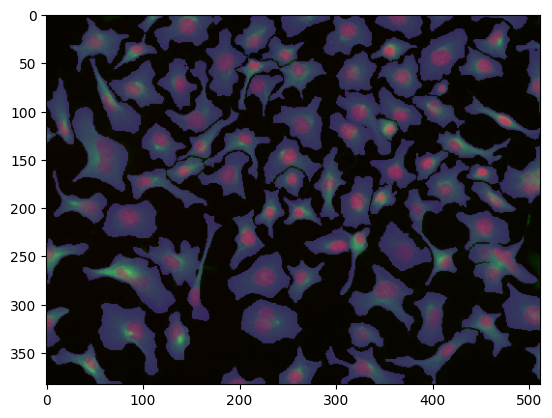

In [73]:
from PIL import Image

img = Image.open("./dataset/train/000_img.png")
mask = Image.open("./dataset/train/000_masks.png")
img = np.array(img)
mask = np.array(mask)

def overlay(image, mask, alpha, resize=None):
    """Combines image and its segmentation mask into a single image.
    https://www.kaggle.com/code/purplejester/showing-samples-with-segmentation-mask-overlay

    Params:
        image: Training image. np.ndarray,
        mask: Segmentation mask. np.ndarray,
        color: Color for segmentation mask rendering.  tuple[int, int, int] = (255, 0, 0)
        alpha: Segmentation mask's transparency. float = 0.5,
        resize: If provided, both image and its mask are resized before blending them together.

    Returns:
        image_combined: The combined image. np.ndarray

    """
    color = list(np.random.choice(range(256), size=3))
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()

    if resize is not None:
        image = cv2.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)

    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)

    return image_combined

img_overlay = overlay(img, mask, alpha=0.4)
plt.imshow(img_overlay)

In [8]:
train_X = [np.array(Image.fromarray(x).convert("L")) for x in train_X]

In [7]:
from tqdm import tqdm
from PIL import Image

train_X = []
train_y = []

data_path = "./dataset/train/"
list_data = sorted(os.listdir(data_path))

for fpath in tqdm(list_data):
    if "img" in fpath:
        img = np.array(Image.open(os.path.join(data_path, fpath)))
        mask_fpath = fpath[:3] + "_masks.png"
        mask = np.array(Image.open(os.path.join(data_path, mask_fpath)))

        train_X.append(img)
        train_y.append(mask)

100%|██████████| 1080/1080 [00:09<00:00, 117.87it/s]


In [38]:
from cellpose import models

In [39]:
model_cell = models.CellposeModel(gpu=False)

In [44]:
sample = torch.rand(2, 128, 128).unsqueeze(0)
x = model_cell.net(sample)
x[0].shape

torch.Size([1, 3, 128, 128])